In [1]:
import geemap, ee, datetime as dt
import pandas as pd
import requests, time
import numpy as np

import os
from dotenv import load_dotenv
from matplotlib import pyplot as plt
import tensorflow as tf
from glob import glob

In [2]:
import geopandas as gpd
from shapely.geometry import Point

### Creating TFRecord Dataset (image dataset)

In [3]:
ee.Initialize(project='stat-288-final-project-458620')

In [4]:
# MODIS land aerosol optical depth, daily 1 km
AOD = ee.ImageCollection("MODIS/061/MCD19A2_GRANULES")

# MODIS 16-day NDVI, 16-day 1 km
NDVI = ee.ImageCollection("MODIS/MCD43A4_006_NDVI")

# VIIRS night-time lights, daily 1 km
VNTL = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG')

BANDS_CORE = ['Optical_Depth_047', 'AOD_QA', 'Column_WV', 'NDVI']        # always available
BAND_NTL   = 'avg_rad'   # monthly night‑lights
PATCH  = 32
SCALE  = 1000

In [5]:
# Print the first image's metadata and bands for each collection
def print_first_image_info(collection, name):
    first_img = collection.first()
    info = first_img.getInfo()
    print(f"--- {name} ---")
    print("ID:", info['id'])
    print("Bands:", [band['id'] for band in info['bands']])
    print("Properties:", list(info['properties'].keys()))
    print()

In [6]:
print_first_image_info(AOD, "AOD")
print_first_image_info(NDVI, "NDVI")
print_first_image_info(VNTL, "Night Lights")

--- AOD ---
ID: MODIS/061/MCD19A2_GRANULES/MCD19A2_A2000055_h00v08_061_2022153215218_01
Bands: ['Optical_Depth_047', 'Optical_Depth_055', 'AOD_Uncertainty', 'Column_WV', 'AOD_QA', 'Injection_Height', 'cosSZA', 'cosVZA', 'RelAZ', 'Scattering_Angle', 'Glint_Angle', 'FineModeFraction', 'AngstromExp_470-780']
Properties: ['SATELLITE', 'system:time_end', 'DESCRREVISION', 'system:time_start', 'ALGORITHMPACKAGENAME', 'LOCALVERSIONID', 'PGEVERSION', 'system:footprint', 'PRODUCTIONDATETIME', 'system:asset_size', 'ALGORITHMPACKAGEVERSION', 'system:index']

--- NDVI ---
ID: MODIS/MCD43A4_006_NDVI/2000_02_24
Bands: ['NDVI']
Properties: ['system:time_start', 'system:time_end', 'system:index']

--- Night Lights ---
ID: NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG/20140101
Bands: ['avg_rad', 'cf_cvg']
Properties: ['system:time_start', 'system:footprint', 'system:time_end', 'system:asset_size', 'system:index']



In [7]:
def weekly_image(start):
    """Return a 4‑ or 5‑band image covering start–start+7 days."""
    start = ee.Date(start)
    end   = start.advance(7, 'day')
    
    # 1. MODIS aerosol + NDVI
    aod  = (AOD.filterDate(start, end)
                .select(['Optical_Depth_047', 'AOD_QA', 'Column_WV'])
                .median())
    ndvi = NDVI.filterDate(start, end).select('NDVI').median()
    base = aod.addBands(ndvi)

    # 2. Monthly night‑lights: pick the *calendar month* containing `start`
    ntl_month = VNTL.filterDate(start, start.advance(1, 'month')).first()
    
    img = ee.Image(ee.Algorithms.If(
        ntl_month,
        base.addBands(ntl_month.select(BAND_NTL).rename('NTL')),  # 5 bands
        base                                                     # 4 bands (no NTL)
    )).set({'system:time_start': start.millis()})
    
    return img

In [16]:
# weekly collection, convert to array bands
def weekly_collection(date_from, date_to):
    start = ee.Date(date_from); stop = ee.Date(date_to)
    n_weeks = stop.difference(start, 'week').round()
    imgs = ee.List.sequence(0, n_weeks.subtract(1)).map(
        lambda i: weekly_image(start.advance(i, 'week')))
    return ee.ImageCollection(imgs)

def to_array(img):
    # Convert every band to array version (whatever bands exist)
    return img.neighborhoodToArray(ee.Kernel.square(PATCH//2, 'pixels'))

ic_arrays = weekly_collection('2018-01-01', '2024-12-31').map(to_array)

In [10]:
df_delhi = pd.read_csv('data/delhi_weekly_pm25.csv')
df_lagos = pd.read_csv('data/lagos_weekly_pm25.csv')
df_bangkok = pd.read_csv('data/bangkok_weekly_pm25.csv')
df_accra = pd.read_csv('data/accra_weekly_pm25.csv')

In [17]:
# create one point per sensor

def df_to_fc(df, city_tag):
    """
    Convert weekly DataFrame -> one‑point‑per‑sensor FeatureCollection.
    Keeps 'sid' as a property and adds a 'city' tag.
    """
    # 1. Get one row per sensor
    sensors = (df[["sid", "latitude", "longitude"]]
               .drop_duplicates())

    # 2. Build a GeoDataFrame with shapely Points
    gdf = gpd.GeoDataFrame(
        sensors,
        geometry=[Point(xy) for xy in zip(sensors.longitude, sensors.latitude)],
        crs="EPSG:4326"
    )

    # 3. Convert to Earth‑Engine FeatureCollection
    fc = geemap.gdf_to_ee(gdf, geodesic=False)

    # 4. Add a 'city' property to every feature
    fc = fc.map(lambda f: f.set({"city": city_tag}))

    return fc

fc_delhi = df_to_fc(df_delhi, "delhi")
fc_lagos = df_to_fc(df_lagos, "lagos")
fc_bangkok = df_to_fc(df_bangkok, "bangkok")
fc_accra = df_to_fc(df_accra, "accra")
print("Delhi sensors:", fc_delhi.size().getInfo())
print("Lagos sensors:", fc_lagos.size().getInfo())
print("Bangkok sensors:", fc_bangkok.size().getInfo())
print("Accra sensors:", fc_accra.size().getInfo())

Delhi sensors: 52
Lagos sensors: 1
Bangkok sensors: 59
Accra sensors: 23


In [18]:
PATCH  = 32                              # pixels (≈ 32 km @ 1‑km MODIS)
SCALE  = 1000                            # meters
kernel = ee.Kernel.square(PATCH // 2, "pixels")

In [19]:
def weekly_samples(img, fc_points):
    return img.sampleRegions(
        collection   = fc_points,
        scale        = SCALE,
        tileScale    = 4,
        geometries   = True
    ).map(lambda f: f.set('week_ms', img.date().millis()))

In [20]:
samples_delhi = ic_arrays.map(lambda img: weekly_samples(img, fc_delhi)).flatten()
samples_lagos = ic_arrays.map(lambda img: weekly_samples(img, fc_lagos)).flatten()
samples_bangkok = ic_arrays.map(lambda img: weekly_samples(img, fc_bangkok)).flatten()
samples_accra = ic_arrays.map(lambda img: weekly_samples(img, fc_accra)).flatten()

In [21]:
# Get the size of the samples_delhi FeatureCollection
print("Delhi samples size:", samples_delhi.size().getInfo())
print("Lagos samples size:", samples_lagos.size().getInfo())
print("Bangkok samples size:", samples_bangkok.size().getInfo())
print("Accra samples size:", samples_accra.size().getInfo())

Delhi samples size: 11278
Lagos samples size: 106
Bangkok samples size: 8059
Accra samples size: 3458


In [ ]:
# ee.batch.Export.table.toDrive(
#     samples_delhi,
#     description='delhi_patches32',
#     fileFormat='TFRecord',
#     selectors=None  # export all properties
# ).start()

# ee.batch.Export.table.toDrive(
#     samples_lagos,
#     description='lagos_patches32',
#     fileFormat='TFRecord',
#     selectors=None  # export all properties
# ).start()

# ee.batch.Export.table.toDrive(
#     samples_bangkok,
#     description='bangkok_patches32',
#     fileFormat='TFRecord',
#     selectors=None  # export all properties
# ).start()

# ee.batch.Export.table.toDrive(
#     samples_accra,
#     description='accra_patches32',
#     fileFormat='TFRecord',
#     selectors=None  # export all properties
# ).start()

In [24]:
# Path to your TFRecord file (update as needed)
filename = "data/delhi_patches32.tfrecord.gz"

# Read the TFRecord file
raw_dataset = tf.data.TFRecordDataset(filename, compression_type="GZIP")

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    for k, v in example.features.feature.items():
        print(f"{k}: {v.WhichOneof('kind')}")

sid: float_list
system:index: bytes_list
Optical_Depth_047: float_list
longitude: float_list
week_ms: float_list
latitude: float_list
NTL: float_list
AOD_QA: float_list
city: bytes_list
NDVI: float_list
Column_WV: float_list


2025-05-04 12:59:23.950169: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:
# Find the date range of the delhi_patches32 and lagos_patches32 TFRecord files
def get_date_range(filename):
    raw_dataset = tf.data.TFRecordDataset(filename, compression_type="GZIP")
    records_list = list(raw_dataset)
    
    # Get the first record
    first_example = tf.train.Example()
    first_example.ParseFromString(records_list[0].numpy())
    first_week_ms = first_example.features.feature['week_ms'].float_list.value[0]
    first_date = dt.datetime.fromtimestamp(first_week_ms/1000).strftime('%Y-%m-%d')
    
    # Get the last record
    last_example = tf.train.Example()
    last_example.ParseFromString(records_list[-1].numpy())
    last_week_ms = last_example.features.feature['week_ms'].float_list.value[0]
    last_date = dt.datetime.fromtimestamp(last_week_ms/1000).strftime('%Y-%m-%d')
    
    return first_date, last_date, len(records_list)

# Delhi patches
delhi_file = "data/delhi_patches32.tfrecord.gz"
delhi_start, delhi_end, delhi_count = get_date_range(delhi_file)
print(f"Delhi patches: {delhi_count} records from {delhi_start} to {delhi_end}")

# Lagos patches (if file exists)
lagos_file = "data/lagos_patches32.tfrecord.gz"
try:
    lagos_start, lagos_end, lagos_count = get_date_range(lagos_file)
    print(f"Lagos patches: {lagos_count} records from {lagos_start} to {lagos_end}")
except (FileNotFoundError, IndexError):
    print("Lagos patches file not found or empty")

Delhi patches: 11278 records from 2017-12-31 to 2024-12-22
Lagos patches: 106 records from 2017-12-31 to 2024-12-22


2025-05-04 12:59:45.692031: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
# Check a single record
filename = "data/delhi_patches32.tfrecord.gz"  
raw_dataset = tf.data.TFRecordDataset(filename, compression_type="GZIP")
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "week_ms"
    value {
      float_list {
        value: 1.51476476e+12
      }
    }
  }
  feature {
    key: "system:index"
    value {
      bytes_list {
        value: "0_0_0"
      }
    }
  }
  feature {
    key: "sid"
    value {
      float_list {
        value: 35
      }
    }
  }
  feature {
    key: "longitude"
    value {
      float_list {
        value: 77.1869354
      }
    }
  }
  feature {
    key: "latitude"
    value {
      float_list {
        value: 28.5632629
      }
    }
  }
  feature {
    key: "city"
    value {
      bytes_list {
        value: "delhi"
      }
    }
  }
  feature {
    key: "Optical_Depth_047"
    value {
      float_list {
        value: 795
        value: 783
        value: 959
        value: 941
        value: 941
        value: 925
        value: 901
        value: 847
        value: 848
        value: 848
        value: 828
        value: 816
        value: 789
        value: 797.5
        value: 779.5
 

Selected random record 6982 of 11278
Record metadata:
Week: 2023-01-15 (timestamp: 1673827188736.0)
Sensor ID: 15629.0
Location: (28.63105010986328, 77.28462219238281)


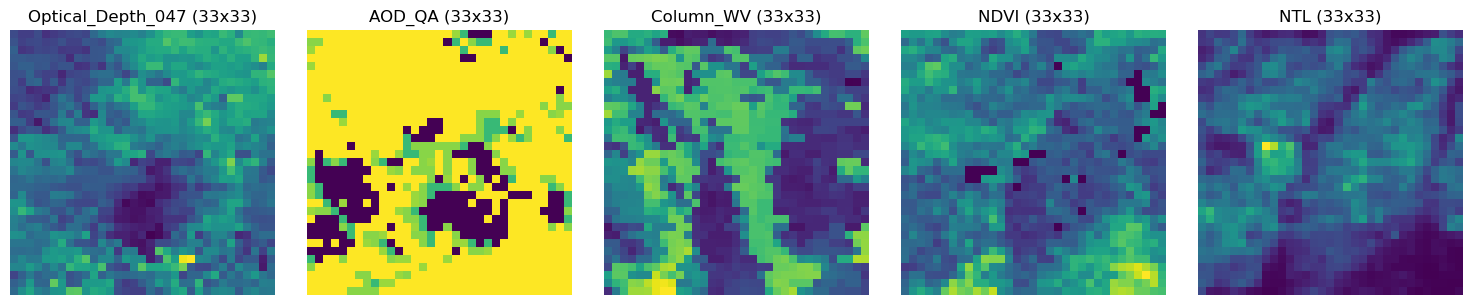

In [27]:
# Read the last record
raw_dataset = tf.data.TFRecordDataset(filename, compression_type="GZIP")
# Convert to list to get a random record
records_list = list(raw_dataset)
if records_list:
    # Choose a random record
    random_index = np.random.randint(0, len(records_list))
    raw_record = records_list[random_index]
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(f"Selected random record {random_index} of {len(records_list)}")
else:
    example = tf.train.Example()

# Print metadata about the record
print("Record metadata:")
if 'week_ms' in example.features.feature:
    week_ms = example.features.feature['week_ms'].float_list.value[0]
    week_date = dt.datetime.fromtimestamp(week_ms/1000).strftime('%Y-%m-%d')
    print(f"Week: {week_date} (timestamp: {week_ms})")
else:
    print("Week timestamp not found")

if 'sid' in example.features.feature:
    sid = example.features.feature['sid'].float_list.value[0]
    print(f"Sensor ID: {sid}")
else:
    print("Sensor ID not found")

if 'latitude' in example.features.feature and 'longitude' in example.features.feature:
    lat = example.features.feature['latitude'].float_list.value[0]
    lon = example.features.feature['longitude'].float_list.value[0]
    print(f"Location: ({lat}, {lon})")
else:
    print("Location coordinates not found")

# List the bands you want to visualize
bands = ['Optical_Depth_047', 'AOD_QA', 'Column_WV', 'NDVI', 'NTL']  # adjust as needed

# Extract and plot each band
fig, axs = plt.subplots(1, len(bands), figsize=(15, 3))
for i, band in enumerate(bands):
    feature = example.features.feature.get(band)
    if feature is None:
        axs[i].set_title(f"{band}\n(Missing)")
        axs[i].axis('off')
        continue
    
    # Try float_list first, then bytes_list
    if feature.float_list.value:
        # Calculate the actual dimensions - sqrt of the array size
        arr_size = len(feature.float_list.value)
        dim = int(np.sqrt(arr_size))
        if dim * dim != arr_size:
            print(f"Warning: {band} has {arr_size} elements, not a perfect square")
            axs[i].set_title(f"{band}\n(Size: {arr_size})")
            axs[i].axis('off')
            continue
        arr = np.array(feature.float_list.value).reshape(dim, dim)
    elif feature.bytes_list.value:
        # For bytes, also calculate dimensions dynamically
        arr = np.frombuffer(feature.bytes_list.value[0], dtype=np.uint16)
        arr_size = len(arr)
        dim = int(np.sqrt(arr_size))
        if dim * dim != arr_size:
            print(f"Warning: {band} has {arr_size} elements, not a perfect square")
            axs[i].set_title(f"{band}\n(Size: {arr_size})")
            axs[i].axis('off')
            continue
        arr = arr.reshape(dim, dim).astype(np.float32)
    else:
        axs[i].set_title(f"{band}\n(Unknown type)")
        axs[i].axis('off')
        continue
    
    axs[i].imshow(arr, cmap='viridis')
    axs[i].set_title(f"{band} ({dim}x{dim})")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

### Train & Test Set Setup (Merging)

In [29]:
def load_tfrecord_data(tfrecord_path):
    """
    Load TFRecord data from the given path. Expects TFRecords with features:
      - 'sid': Sensor ID (float)
      - 'week_ms': Week start timestamp in milliseconds (float)
      - 'Optical_Depth_047': AOD values (float_list)
      - 'AOD_QA': Quality assurance values (float_list)
      - 'NDVI': Normalized Difference Vegetation Index values (float_list)
      - 'Column_WV': Column water vapor values (float_list)
      - 'longitude', 'latitude': Coordinates (float)
      - 'city': City name (bytes)
    Returns:
      A pandas DataFrame with columns ['sid', 'week_ms', 'patch'].
      'sid' is int, 'week_ms' is int, and 'patch' is a numpy array of shape (32, 32, 4)
      where the 4 channels are [Optical_Depth_047, AOD_QA, NDVI, Column_WV].
    """
    PATCH = 33
    bands = ['Optical_Depth_047', 'AOD_QA', 'NDVI', 'Column_WV']
    data = []
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path, compression_type="GZIP")
    for raw_record in raw_dataset:
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        features = example.features.feature
        
        # Extract sensor ID
        sid = int(features['sid'].float_list.value[0])
        
        # Extract week timestamp (ms since epoch)
        week_ms = int(features['week_ms'].float_list.value[0])
        
        # Extract coordinates
        longitude = features['longitude'].float_list.value[0]
        latitude = features['latitude'].float_list.value[0]
        
        # Extract the four bands to create the patch
        patch = []
        for band in bands:
            arr = features[band].float_list.value
            if len(arr) == PATCH * PATCH:
                arr = np.array(arr).reshape(PATCH, PATCH)
            else:
                arr = np.zeros((PATCH, PATCH), dtype=np.float32)
            patch.append(arr)
        patch = np.stack(patch, axis=-1)
        
        # Append to list
        data.append({
            'sid': sid, 
            'week_ms': week_ms, 
            'longitude': longitude,
            'latitude': latitude,
            'patch': patch
        })
        
        # Optional: extract city if needed
        if 'city' in features:
            data[-1]['city'] = features['city'].bytes_list.value[0].decode('utf-8')
            
    return pd.DataFrame(data)

In [30]:
def load_csv_data(csv_path):
    """
    Load the OpenAQ weekly PM2.5 CSV from the given path.
    Returns:
      A pandas DataFrame with columns ['sid', 'week', 'pm25_mean', 'year', 'week_ms'].
      - 'sid' is int
      - 'week' is the week start date string (YYYY-MM-DD)
      - 'pm25_mean' is float
      - 'year' is int (year of the week)
      - 'week_ms' is int (timestamp in ms for the week start)
    """
    df = pd.read_csv(csv_path)
    # Ensure correct dtypes
    if 'sid' in df.columns:
        df['sid'] = df['sid'].astype(int)
    if 'pm25_mean' in df.columns:
        df['pm25_mean'] = df['pm25_mean'].astype(float)
    # Parse week dates to datetime and extract year and timestamp
    if 'week' in df.columns:
        df['date'] = pd.to_datetime(df['week'])
    else:
        # If no 'week' column (unlikely in our case), try 'week_ms'
        if 'week_ms' in df.columns:
            df['date'] = pd.to_datetime(df['week_ms'], unit='ms')
        else:
            raise ValueError("CSV must contain 'week' or 'week_ms' column for dates.")
    df['year'] = df['date'].dt.year
    # Convert week start to milliseconds timestamp (epoch)
    # Use floor division by 1e6 because pandas datetime is in ns.
    df['week_ms'] = (df['date'].astype(np.int64) // 10**6).astype(np.int64)
    return df[['sid', 'week', 'pm25_mean', 'year', 'week_ms']]

In [46]:
def build_cnn_model(input_shape=(PATCH,PATCH,4)):
    inp = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32,3,activation='relu')(inp)
    x = tf.keras.layers.Conv2D(32,3,activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    x = tf.keras.layers.Conv2D(64,3,activation='relu')(x)
    x = tf.keras.layers.Conv2D(64,3,activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    out = tf.keras.layers.Dense(1)(x)
    m = tf.keras.Model(inp,out)
    m.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
              loss='mse', metrics=['mae'])
    return m

In [60]:
def train_model(model, X_tr, y_tr, X_va, y_va):
    """
    Train the CNN model on Delhi + Bangkok training data and evaluate on validation data.
    Early stopping is used to prevent overfitting.
    Returns the trained model.
    """
    es = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    model.fit(
        X_tr, y_tr,
        validation_data=(X_va,y_va),
        epochs=30, batch_size=32,
        callbacks=[es],
        verbose=2
    )
    return model

In [97]:
def fine_tune_on_lagos(model, X_train, y_train, baseline_model=None):
    """
    Fine-tune the model on Lagos data.
    If the Lagos training set is small (< 100 samples), perform linear regression correction (y_adj = α + β * y_pred).
    If larger, freeze early conv layers and fine-tune the dense head with a low learning rate.
    Params:
      model: Trained source model (after Delhi training).
      X_train, y_train: Lagos training data (patches and labels).
      baseline_model: (Optional) original model to use for predictions in linear mode if model gets modified.
    Returns:
      If linear correction is used, returns (alpha, beta) coefficients.
      If fine-tuning is done, returns the fine-tuned model.
    """
    n = X_train.shape[0]
    if n < 100:
        # Linear calibration approach
        if baseline_model is None:
            baseline_model = model
        # Get predictions from the baseline (Delhi-trained) model
        y_pred = baseline_model.predict(X_train).reshape(-1)
        y_true = y_train.reshape(-1)
        # Fit linear least squares: y_true = alpha + beta * y_pred
        A = np.vstack([np.ones(n), y_pred]).T
        # Solve for [alpha, beta]
        coeffs, _, _, _ = np.linalg.lstsq(A, y_true, rcond=None)
        alpha, beta = coeffs[0], coeffs[1]
        print(f"Lagos calibration: alpha = {alpha:.3f}, beta = {beta:.3f}")
        return (alpha, beta)
    else:
        # Fine-tune CNN on Lagos
        # Freeze convolutional layers to retain Delhi features
        for layer in model.layers:
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer.trainable = False
        # Recompile with a smaller learning rate for fine-tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
        # Fine-tune on Lagos data with higher sample weight
        sample_weight = np.ones(n) * 5.0
        model.fit(X_train, y_train, epochs=20, batch_size=8, sample_weight=sample_weight, verbose=2)
        return model

In [98]:
def evaluate_on_lagos(model, X_test, y_test, adaptation=None):
    """
    Evaluate the model (and optionally an adapted version) on Lagos test data.
    If adaptation is a tuple (alpha, beta), use linear calibration on the model's predictions.
    If adaptation is a model (fine-tuned), use it directly for predictions.
    Prints out RMSE and R^2 for zero-shot vs fine-tuned, and AUROC for WHO threshold exceedance.
    """
    # Ground truth
    y_true = y_test.reshape(-1)
    # Baseline (zero-shot) predictions using original model
    y_pred_base = model.predict(X_test).reshape(-1)
    # If adaptation provided, get adapted predictions
    if adaptation is None:
        # No adaptation, use baseline only
        y_pred_adapt = None
    elif isinstance(adaptation, tuple):
        # Linear calibration: adaptation = (alpha, beta)
        alpha, beta = adaptation
        y_pred_adapt = alpha + beta * y_pred_base
    else:
        # Adaptation is a fine-tuned model
        y_pred_adapt = adaptation.predict(X_test).reshape(-1)
    # Compute metrics for baseline
    rmse_base = np.sqrt(np.mean((y_pred_base - y_true) ** 2))
    mae_base = np.mean(np.abs(y_pred_base - y_true))
    # R^2 (coefficient of determination) for baseline
    ss_res_base = np.sum((y_true - y_pred_base) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2_base = 1 - ss_res_base/ss_tot if ss_tot != 0 else 0.0
    print(f"Lagos 2023 (Zero-shot) – RMSE: {rmse_base:.2f}, MAE: {mae_base:.2f}, R^2: {r2_base:.3f}")
    if y_pred_adapt is not None:
        # Compute metrics for adapted model
        rmse_adapt = np.sqrt(np.mean((y_pred_adapt - y_true) ** 2))
        mae_adapt = np.mean(np.abs(y_pred_adapt - y_true))
        ss_res_adapt = np.sum((y_true - y_pred_adapt) ** 2)
        r2_adapt = 1 - ss_res_adapt/ss_tot if ss_tot != 0 else 0.0
        print(f"Lagos 2023 (Fine-tuned) – RMSE: {rmse_adapt:.2f}, MAE: {mae_adapt:.2f}, R^2: {r2_adapt:.3f}")
    # WHO 15 µg/m³ exceedance classification
    # Create binary labels for exceedance (1 if >=15, 0 if below 15)
    threshold = 15.0  # µg/m³ WHO guideline threshold
    y_true_exceed = (y_true >= threshold).astype(int)
    
    # Check if we have both classes (0 and 1) in y_true_exceed before calculating AUROC
    unique_classes = np.unique(y_true_exceed)
    if len(unique_classes) > 1:
        # Calculate AUROC for baseline predictions
        auc_base = roc_auc_score(y_true_exceed, y_pred_base)
        if y_pred_adapt is not None:
            auc_adapt = roc_auc_score(y_true_exceed, y_pred_adapt)
            print(f"Lagos 2023 – WHO 15 µg/m³ exceedance AUROC: baseline = {auc_base:.3f}, fine-tuned = {auc_adapt:.3f}")
        else:
            print(f"Lagos 2023 – WHO 15 µg/m³ exceedance AUROC: baseline = {auc_base:.3f}")
    else:
        # Handle the case where all values are the same class
        class_value = unique_classes[0]
        print(f"Lagos 2023 – All PM2.5 values are {'above' if class_value == 1 else 'below'} the WHO 15 µg/m³ threshold. AUROC not defined.")

In [32]:
# File paths
delhi_tf_path = "data/delhi_patches32.tfrecord.gz"
lagos_tf_path = "data/lagos_patches32.tfrecord.gz"
bangkok_tf_path = "data/bangkok_patches32.tfrecord.gz"
accra_tf_path = "data/accra_patches32.tfrecord.gz"

delhi_csv_path = "data/delhi_weekly_pm25.csv"
lagos_csv_path = "data/lagos_weekly_pm25.csv"
bangkok_csv_path = "data/bangkok_weekly_pm25.csv"
accra_csv_path = "data/accra_weekly_pm25.csv"

In [33]:
# Load TFRecord and CSV data
print("Loading Delhi TFRecord data...")
delhi_patches = load_tfrecord_data(delhi_tf_path)
print(f"Loaded {len(delhi_patches)} Delhi patch samples.")
print("Loading Lagos TFRecord data...")
lagos_patches = load_tfrecord_data(lagos_tf_path)
print(f"Loaded {len(lagos_patches)} Lagos patch samples.")
print("Loading Bangkok TFRecord data...")
bangkok_patches = load_tfrecord_data(bangkok_tf_path)
print(f"Loaded {len(bangkok_patches)} Bangkok patch samples.")
print("Loading Accra TFRecord data...")
accra_patches = load_tfrecord_data(accra_tf_path)
print(f"Loaded {len(accra_patches)} Accra patch samples.")
print("Loading Delhi labels CSV...")
delhi_labels = load_csv_data(delhi_csv_path)
print(f"Loaded {len(delhi_labels)} Delhi label entries.")
print("Loading Lagos labels CSV...")
lagos_labels = load_csv_data(lagos_csv_path)
print(f"Loaded {len(lagos_labels)} Lagos label entries.")
print("Loading Bangkok labels CSV...")
bangkok_labels = load_csv_data(bangkok_csv_path)
print(f"Loaded {len(bangkok_labels)} Bangkok label entries.")
print("Loading Accra labels CSV...")
accra_labels = load_csv_data(accra_csv_path)
print(f"Loaded {len(accra_labels)} Accra label entries.")

Loading Delhi TFRecord data...
Loaded 11278 Delhi patch samples.
Loading Lagos TFRecord data...
Loaded 106 Lagos patch samples.
Loading Bangkok TFRecord data...


2025-05-04 13:13:31.299947: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loaded 8059 Bangkok patch samples.
Loading Accra TFRecord data...
Loaded 3458 Accra patch samples.
Loading Delhi labels CSV...
Loaded 3975 Delhi label entries.
Loading Lagos labels CSV...
Loaded 50 Lagos label entries.
Loading Bangkok labels CSV...
Loaded 10075 Bangkok label entries.
Loading Accra labels CSV...
Loaded 726 Accra label entries.


In [36]:
# Add week column to patches
delhi_patches['week'] = pd.to_datetime(delhi_patches['week_ms'], unit='ms').dt.strftime('%Y-%m-%d')
lagos_patches['week'] = pd.to_datetime(lagos_patches['week_ms'], unit='ms').dt.strftime('%Y-%m-%d')
bangkok_patches['week'] = pd.to_datetime(bangkok_patches['week_ms'], unit='ms').dt.strftime('%Y-%m-%d')
accra_patches['week'] = pd.to_datetime(accra_patches['week_ms'], unit='ms').dt.strftime('%Y-%m-%d')

In [37]:
# Combining Delhi + Bangkok to make a larger training set
train_patches = pd.concat([delhi_patches, bangkok_patches], ignore_index=True)
train_labels = pd.concat([delhi_labels, bangkok_labels], ignore_index=True)

In [40]:
# Use isoyear and isoweek to merge patches and labels

for df in [train_patches, train_labels, lagos_patches, lagos_labels, accra_patches, accra_labels]:
    df['week_dt'] = pd.to_datetime(df['week'], errors='coerce')
    df['iso_year'] = df['week_dt'].dt.isocalendar().year
    df['iso_week'] = df['week_dt'].dt.isocalendar().week

In [41]:
# Training data
train_merged = pd.merge(
    train_patches, train_labels,
    on=['sid', 'iso_year', 'iso_week'],
    how='inner'
)

# Accra data: for evaluation
accra_merged = pd.merge(
    accra_patches, accra_labels,
    on=['sid', 'iso_year', 'iso_week'],
    how='inner'
)

# Lagos data: for evaluation
lagos_merged = pd.merge(
    lagos_patches, lagos_labels,
    on=['sid', 'iso_year', 'iso_week'],
    how='inner'
)

In [42]:
print(len(train_merged))
print(len(accra_merged))
print(len(lagos_merged))
train_merged

6160
428
13


,sid,week_ms_x,longitude,latitude,patch,city,week_x,week_dt_x,iso_year,iso_week,week_y,pm25_mean,year,week_ms_y,week_dt_y
0,35,1514764763136,77.186935,28.563263,"[[[795.0, 1280.0, 0.22233502566814423, 812.0],...",delhi,2017-12-31,2017-12-31,2017,52,2017-12-26,259.000000,2017,1514246400000,2017-12-26
1,388,1514764763136,77.200500,28.634100,"[[[824.0, 1280.0, 0.30079999566078186, 798.0],...",delhi,2017-12-31,2017-12-31,2017,52,2017-12-26,377.000000,2017,1514246400000,2017-12-26
2,13860,1514764763136,77.158096,28.651699,"[[[803.0, 1282.0, 0.0, 831.5], [814.0, 1280.0,...",delhi,2017-12-31,2017-12-31,2017,52,2017-12-26,349.000000,2017,1514246400000,2017-12-26
3,13861,1514764763136,77.249397,28.623501,"[[[725.0, 1280.0, 0.0, 799.0], [801.5, 1057.0,...",delhi,2017-12-31,2017-12-31,2017,52,2017-12-26,235.500000,2017,1514246400000,2017-12-26
4,13900,1514764763136,77.313774,28.410122,"[[[945.0, 1283.0, 0.5579235553741455, 928.5], ...",delhi,2017-12-31,2017-12-31,2017,52,2017-12-26,260.000000,2017,1514246400000,2017-12-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6155,1304438,1734911983616,100.732079,13.813578,"[[[291.0, 1283.0, 0.0, 2019.0], [298.0, 1281.0...",bangkok,2024-12-22,2024-12-22,2024,51,2024-12-17,32.800000,2024,1734393600000,2024-12-17
6156,1304524,1734911983616,100.646011,13.779873,"[[[348.5, 1282.0, 0.0, 2214.0], [441.5, 1282.5...",bangkok,2024-12-22,2024-12-22,2024,51,2024-12-17,29.414286,2024,1734393600000,2024-12-17
6157,1305020,1734911983616,100.474373,13.729431,"[[[371.5, 1280.0, 0.0, 2250.0], [342.0, 1281.0...",bangkok,2024-12-22,2024-12-22,2024,51,2024-12-17,37.785714,2024,1734393600000,2024-12-17
6158,5077771,1734911983616,100.486565,13.727622,"[[[357.0, 1281.0, 0.0, 2295.0], [369.0, 1280.0...",bangkok,2024-12-22,2024-12-22,2024,51,2024-12-17,37.428571,2024,1734393600000,2024-12-17


### CNN Training & Evaluation

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns

In [45]:
# Split the data into training and test sets by random sampling (not by time)
# For Training Data (Delhi + Bangkok): 80% training, 20% validation
train_df, val_df = train_test_split(train_merged, test_size=0.2, random_state=42)

# Print the shapes to verify the split
print(f"Delhi + BK data: {len(train_merged)} total samples")
print(f"Delhi + BK training: {len(train_df)} samples, Delhi + BK test: {len(val_df)} samples")

# Verify that the splits are random across time (not time-based)
print("\nDistribution of years in Delhi + BK training set:")
print(train_df['year'].value_counts().sort_index())
print("\nDistribution of years in Delhi + BK validation set:")
print(val_df['year'].value_counts().sort_index())


Delhi + BK data: 6160 total samples
Delhi + BK training: 4928 samples, Delhi + BK test: 1232 samples

Distribution of years in Delhi + BK training set:
year
2017       5
2018     290
2019     145
2020     499
2021     651
2022     659
2023    1326
2024    1353
Name: count, dtype: int64

Distribution of years in Delhi + BK validation set:
year
2018     92
2019     42
2020    129
2021    149
2022    163
2023    334
2024    323
Name: count, dtype: int64


In [63]:
sample_patch = train_df['patch'].iloc[0]
input_shape = sample_patch.shape  # e.g., (32, 32, 1) or (32, 32, 3)

model = build_cnn_model(input_shape)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 33, 33, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 31, 31, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,305 (290.25 KB)

 Trainable params: 74,305 (290.25 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Prepare X,y arrays
def df_to_xy(df):
    X = np.stack(df['patch'].values).astype(np.float32)
    y = df['pm25_mean'].values.astype(np.float32)
    return X,y

X_tr, y_tr = df_to_xy(train_df)
X_va, y_va = df_to_xy(val_df)

In [65]:
# Pre-train on Delhi + Bangkok
model = train_model(model, X_tr, y_tr, X_va, y_va)

Epoch 1/30
154/154 - 4s - 27ms/step - loss: 1376.7382 - mae: 23.3306 - val_loss: 1042.5875 - val_mae: 19.1231
Epoch 2/30
154/154 - 3s - 22ms/step - loss: 1019.7886 - mae: 19.9189 - val_loss: 1009.8134 - val_mae: 18.3429
Epoch 3/30
154/154 - 3s - 21ms/step - loss: 959.9017 - mae: 19.1191 - val_loss: 957.6639 - val_mae: 19.0380
Epoch 4/30
154/154 - 3s - 20ms/step - loss: 919.4395 - mae: 18.5542 - val_loss: 1003.9274 - val_mae: 20.2400
Epoch 5/30
154/154 - 3s - 20ms/step - loss: 918.2902 - mae: 18.4717 - val_loss: 1047.2450 - val_mae: 19.6101
Epoch 6/30
154/154 - 3s - 22ms/step - loss: 902.7322 - mae: 17.8616 - val_loss: 1033.3748 - val_mae: 18.7933


In [66]:
# The 'model' variable is actually a History object returned from model.fit()
baseline_model = model

# Save the model locally
print("Saving model to disk...")
model_save_path = 'models/delhi_bangkok_pm25_cnn_model_v2.keras'  
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Saving model to disk...
Model saved to models/delhi_bangkok_pm25_cnn_model_v2.keras


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Delhi Test → RMSE=48.60, R²=0.311
Bangkok Test → RMSE=15.71, R²=-1.299


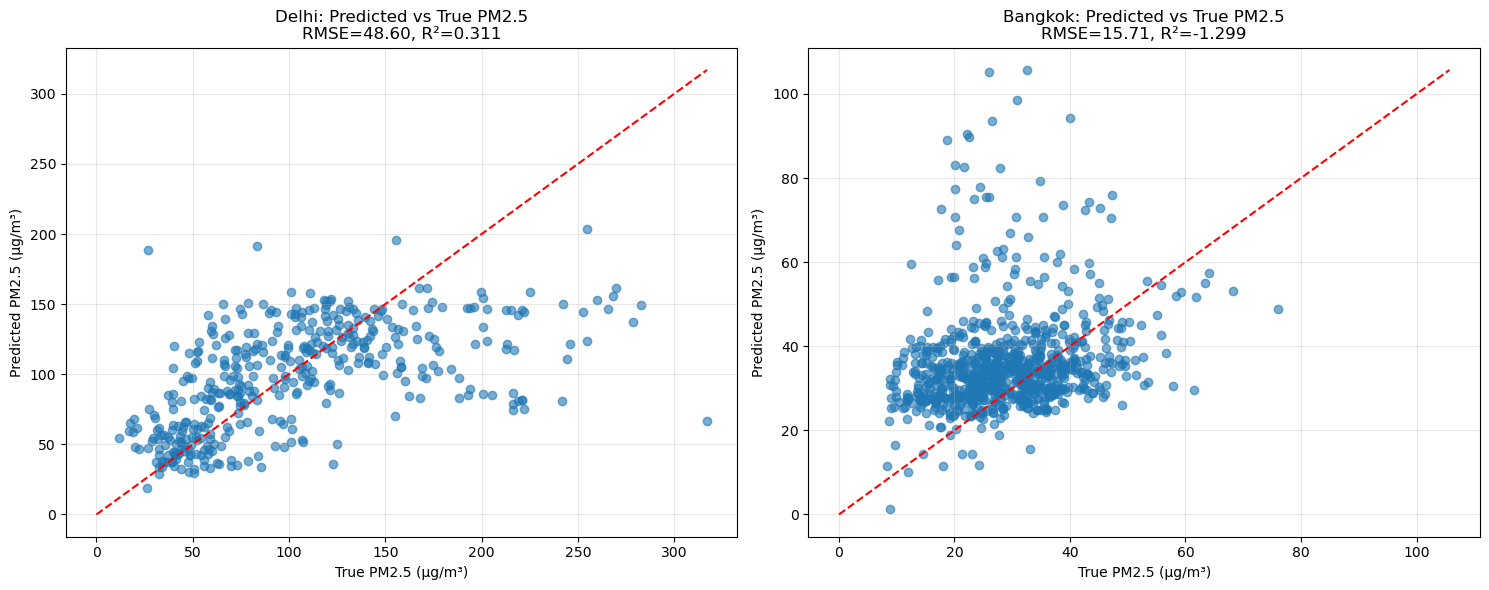

In [115]:
# Evaluate and plot predictions for Delhi and Bangkok separately

# First, separate Delhi and Bangkok data from the validation set
delhi_val_df = val_df[val_df['city'] == 'delhi'].reset_index(drop=True)
bangkok_val_df = val_df[val_df['city'] == 'bangkok'].reset_index(drop=True)

# Convert to X,y arrays
X_delhi, y_delhi = df_to_xy(delhi_val_df)
X_bangkok, y_bangkok = df_to_xy(bangkok_val_df)

# Make predictions
y_delhi_pred = model.predict(X_delhi).ravel()
y_bangkok_pred = model.predict(X_bangkok).ravel()

# Calculate metrics for Delhi
rmse_delhi = np.sqrt(mean_squared_error(y_delhi, y_delhi_pred))
r2_delhi = r2_score(y_delhi, y_delhi_pred)
print(f"Delhi Test → RMSE={rmse_delhi:.2f}, R²={r2_delhi:.3f}")

# Calculate metrics for Bangkok
rmse_bangkok = np.sqrt(mean_squared_error(y_bangkok, y_bangkok_pred))
r2_bangkok = r2_score(y_bangkok, y_bangkok_pred)
print(f"Bangkok Test → RMSE={rmse_bangkok:.2f}, R²={r2_bangkok:.3f}")

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Delhi predictions vs true values
ax1.scatter(y_delhi, y_delhi_pred, alpha=0.6)
ax1.plot([0, max(y_delhi.max(), y_delhi_pred.max())], 
         [0, max(y_delhi.max(), y_delhi_pred.max())], 
         'r--')
ax1.set_xlabel('True PM2.5 (μg/m³)')
ax1.set_ylabel('Predicted PM2.5 (μg/m³)')
ax1.set_title(f'Delhi: Predicted vs True PM2.5\nRMSE={rmse_delhi:.2f}, R²={r2_delhi:.3f}')
ax1.grid(True, alpha=0.3)

# Plot Bangkok predictions vs true values
ax2.scatter(y_bangkok, y_bangkok_pred, alpha=0.6)
ax2.plot([0, max(y_bangkok.max(), y_bangkok_pred.max())], 
         [0, max(y_bangkok.max(), y_bangkok_pred.max())], 
         'r--')
ax2.set_xlabel('True PM2.5 (μg/m³)')
ax2.set_ylabel('Predicted PM2.5 (μg/m³)')
ax2.set_title(f'Bangkok: Predicted vs True PM2.5\nRMSE={rmse_bangkok:.2f}, R²={r2_bangkok:.3f}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Count data points in Accra dataset by year
year_counts = accra_merged['year'].value_counts().sort_index()
for year, count in year_counts.items():
    print(f"Accra data points in {year}: {count}")

# Group counts for analysis periods
accra_before_2023 = accra_merged[accra_merged['year'] < 2023]
accra_2023 = accra_merged[accra_merged['year'] == 2023]
accra_after_2023 = accra_merged[accra_merged['year'] > 2023]

print(f"\nAccra data points before 2023: {len(accra_before_2023)}")
print(f"Accra data points in 2023: {len(accra_2023)}")
print(f"Accra data points after 2023: {len(accra_after_2023)}")

# Total count as a sanity check
print(f"Total Accra data points: {len(accra_merged)}")


Accra data points in 2020: 17
Accra data points in 2021: 22
Accra data points in 2022: 21
Accra data points in 2023: 52
Accra data points in 2024: 316

Accra data points before 2023: 60
Accra data points in 2023: 52
Accra data points after 2023: 316
Total Accra data points: 428


In [73]:
# assume `accra_df` has columns ['sid','week','pm25_mean','year', ...]
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in splitter.split(accra_merged, accra_merged['year']):
    accra_train = accra_merged.iloc[train_idx].reset_index(drop=True)
    accra_test  = accra_merged.iloc[test_idx].reset_index(drop=True)

print("Accra train size:", len(accra_train))
print("Accra test size: ", len(accra_test))
print(accra_train['year'].value_counts(normalize=True))
print(accra_test['year'].value_counts(normalize=True))

Accra train size: 342
Accra test size:  86
year
2024    0.736842
2023    0.119883
2021    0.052632
2022    0.049708
2020    0.040936
Name: proportion, dtype: float64
year
2024    0.744186
2023    0.127907
2021    0.046512
2022    0.046512
2020    0.034884
Name: proportion, dtype: float64


In [84]:
# Zero-shot evaluation on Accra 2023
X_acc23, y_acc23 = df_to_xy(accra_test)

y0 = model.predict(X_acc23).ravel()
rmse0 = np.sqrt(mean_squared_error(y_acc23,y0))
r2_0  = r2_score(y_acc23,y0)
print(f"Accra 2023 Zero-shot → RMSE={rmse0:.2f}, R²={r2_0:.3f}")

# Evaluate on Delhi/Bangkok test set for comparison
X_test, y_test = df_to_xy(val_df)
y_test_pred = model.predict(X_test).ravel()
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)
print(f"Delhi/Bangkok Test → RMSE={rmse_test:.2f}, R²={r2_test:.3f}")

# Compare performance
print(f"Performance gap: RMSE difference = {rmse0-rmse_test:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
Accra 2023 Zero-shot → RMSE=20.13, R²=-1.898
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Delhi/Bangkok Test → RMSE=30.95, R²=0.610
Performance gap: RMSE difference = -10.81


In [75]:
# Scarcity sweep on Accra

res = []
for N in [200,100,50,20,10]:
    if len(accra_train)<N: continue
    sub = accra_train.sample(N,random_state=42)
    Xn, yn = df_to_xy(sub)

    # clone & freeze conv blocks
    m2 = tf.keras.models.clone_model(model)
    m2.set_weights(model.get_weights())
    # freeze first 2 conv layers
    conv_layers = [l for l in m2.layers if isinstance(l, tf.keras.layers.Conv2D)]
    for l in conv_layers[:2]: l.trainable=False

    m2.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')
    m2.fit(Xn,yn, epochs=10, batch_size=8, verbose=0,
           sample_weight=np.ones_like(yn)*5)

    y_pred = m2.predict(X_acc23).ravel()
    rmse = np.sqrt(mean_squared_error(y_acc23,y_pred))
    res.append((N,rmse))
    print(f"N={N:3d} → RMSE={rmse:.2f}")

# compare to RMSE0
print("Zero-shot RMSE:", rmse0)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
N=200 → RMSE=7.94
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
N=100 → RMSE=10.60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
N= 50 → RMSE=12.11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
N= 20 → RMSE=11.89
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
N= 10 → RMSE=13.48
Zero-shot RMSE: 20.131624


The elbow point appears to be at N=20 with RMSE=11.89
This suggests that using 20 training samples provides a good trade-off between
model performance and annotation effort for Accra.


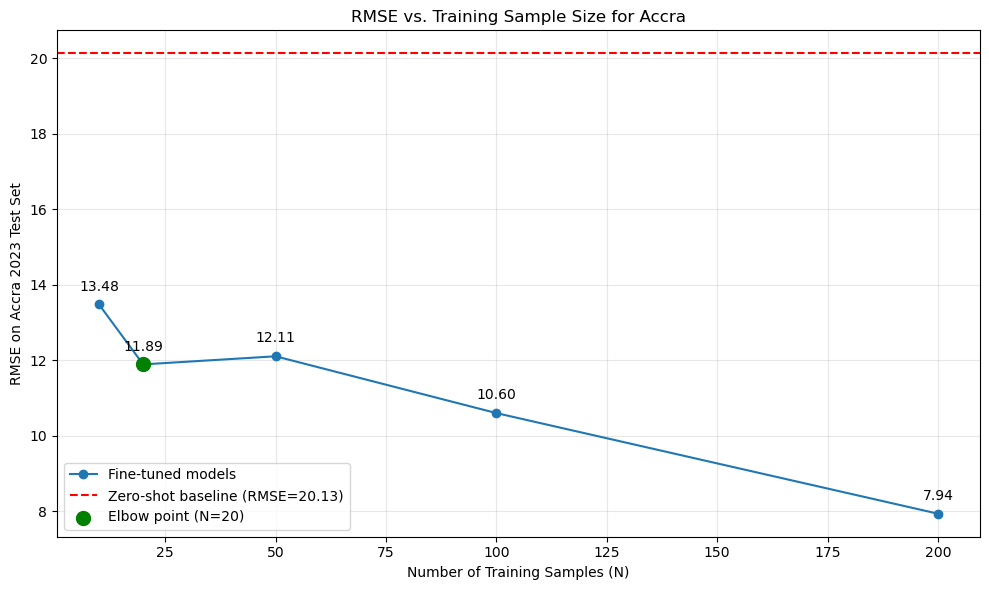

In [77]:
# Plot RMSE vs N to find the "elbow" point

# Extract N and RMSE values from results
N_values = [r[0] for r in res]
rmse_values = [r[1] for r in res]

# Add zero-shot baseline
plt.figure(figsize=(10, 6))
plt.plot(N_values, rmse_values, 'o-', label='Fine-tuned models')
plt.axhline(y=rmse0, color='r', linestyle='--', label=f'Zero-shot baseline (RMSE={rmse0:.2f})')

plt.xlabel('Number of Training Samples (N)')
plt.ylabel('RMSE on Accra 2023 Test Set')
plt.title('RMSE vs. Training Sample Size for Accra')
plt.grid(True, alpha=0.3)
plt.legend()

for i, rmse in enumerate(rmse_values):
    plt.annotate(f'{rmse:.2f}', 
                 (N_values[i], rmse_values[i]),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

# Find the "elbow" point 
if len(N_values) >= 3:
    slopes = [rmse_values[i+1] - rmse_values[i] for i in range(len(rmse_values)-1)]
    slope_changes = [abs(slopes[i+1] - slopes[i]) for i in range(len(slopes)-1)]
    if slope_changes:
        elbow_idx = slope_changes.index(max(slope_changes)) + 1
        elbow_N = N_values[elbow_idx]

        plt.scatter([elbow_N], [rmse_values[elbow_idx]], color='green', s=100, 
                   label=f'Elbow point (N={elbow_N})', zorder=5)
        plt.legend()

        print(f"The elbow point appears to be at N={elbow_N} with RMSE={rmse_values[elbow_idx]:.2f}")
        print(f"This suggests that using {elbow_N} training samples provides a good trade-off between")
        print(f"model performance and annotation effort for Accra.")

plt.tight_layout()
plt.show()


In [82]:
# Best point: model with N=20 samples
N = 20
if len(accra_train) >= N:
    sub = accra_train.sample(N, random_state=42)
    Xn, yn = df_to_xy(sub)

    # clone & freeze conv blocks
    m2 = tf.keras.models.clone_model(model)
    m2.set_weights(model.get_weights())
    # freeze first 2 conv layers
    conv_layers = [l for l in m2.layers if isinstance(l, tf.keras.layers.Conv2D)]
    for l in conv_layers[:2]: l.trainable=False

    m2.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')
    m2.fit(Xn, yn, epochs=10, batch_size=8, verbose=0,
           sample_weight=np.ones_like(yn)*5)

    y_pred = m2.predict(X_acc23).ravel()
    rmse = np.sqrt(mean_squared_error(y_acc23, y_pred))
    res.append((N, rmse, m2))
    print(f"N={N:3d} → RMSE={rmse:.2f}")
    
    # Save the model
    n20_model = m2
    # Save the model locally
    n20_model.save('models/accra_n20_model.keras')
    print(f"N=20 model saved to 'models/accra_n20_model.keras'")
else:
    print(f"Not enough samples in accra_train (needed {N})")

# compare to RMSE0
print("Zero-shot RMSE:", rmse0)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
N= 20 → RMSE=12.56
N=20 model saved to 'models/accra_n20_model.keras'
Zero-shot RMSE: 20.131624


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Performance of N=20 model on Lagos data:
RMSE: 20.07
MAE: 16.46

Predictions for Lagos data points:
    Actual PM2.5  Predicted PM2.5  Absolute Error
0      20.800000         0.279632       20.520368
1      12.854286         5.580353        7.273933
2      13.972857        16.787333        2.814475
3       8.831429        -5.486019       14.317448
4      16.148571         9.404598        6.743973
5      14.100000        22.631491        8.531491
6      22.257143        62.163742       39.906599
7      10.571429        12.460737        1.889309
8      13.731429        34.267780       20.536352
9      17.991429         8.246712        9.744717
10     16.820000        36.292656       19.472656
11     16.820000        48.650681       31.830681
12     26.100000        56.526829       30.426829


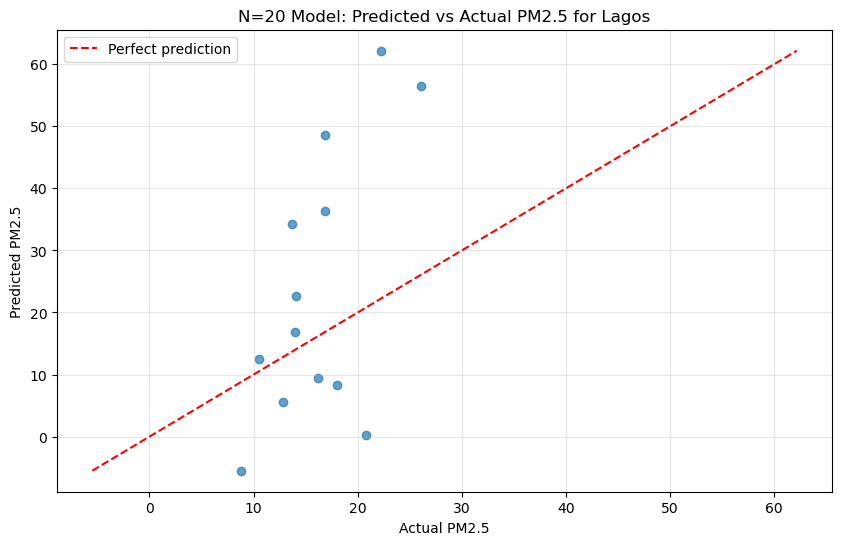

In [83]:
# Evaluate the model with N=20 on Lagos data

if n20_model is None:
    print("No model with N=20 found in results.")
else:
    # Prepare Lagos data for prediction
    X_lagos = np.stack(lagos_merged['patch'].values)
    y_lagos_true = lagos_merged['pm25_mean'].values
    
    # Make predictions
    y_lagos_pred = n20_model.predict(X_lagos)
    
    # Calculate metrics
    lagos_rmse = np.sqrt(np.mean((y_lagos_pred.flatten() - y_lagos_true) ** 2))
    lagos_mae = np.mean(np.abs(y_lagos_pred.flatten() - y_lagos_true))
    
    print(f"\nPerformance of N=20 model on Lagos data:")
    print(f"RMSE: {lagos_rmse:.2f}")
    print(f"MAE: {lagos_mae:.2f}")
    
    # Create a scatter plot of predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_lagos_true, y_lagos_pred, alpha=0.7)
    
    # Add perfect prediction line
    min_val = min(min(y_lagos_true), min(y_lagos_pred))
    max_val = max(max(y_lagos_true), max(y_lagos_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')
    
    plt.xlabel('Actual PM2.5')
    plt.ylabel('Predicted PM2.5')
    plt.title('N=20 Model: Predicted vs Actual PM2.5 for Lagos')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add a table with the predictions
    results_df = pd.DataFrame({
        'Actual PM2.5': y_lagos_true,
        'Predicted PM2.5': y_lagos_pred.flatten(),
        'Absolute Error': np.abs(y_lagos_pred.flatten() - y_lagos_true)
    })
    
    print("\nPredictions for Lagos data points:")
    print(results_df)


### Visualize predictions on Lagos

In [110]:
import folium
from folium.plugins import HeatMap
import branca.colormap as cm
from shapely.geometry import Polygon, Point

In [95]:
def df_to_gdf(df, lon="longitude", lat="latitude", crs="EPSG:4326"):
    """Convert df[lon,lat] to a GeoDataFrame."""
    gdf = gpd.GeoDataFrame(
        df.copy(),
        geometry=[Point(xy) for xy in zip(df[lon], df[lat])],
        crs=crs
    )
    return gdf

In [96]:
def plot_point_map(gdf, val_col="prediction", center=None, zoom=8, title="Predicted PM2.5"):
    # build a linear colormap
    vmin, vmax = float(gdf[val_col].min()), float(gdf[val_col].max())
    cmap = cm.linear.YlOrRd_09.scale(vmin, vmax)
    cmap.caption = f"{title} ({val_col})"

    # init map
    if center is None:
        center = [gdf.geometry.y.mean(), gdf.geometry.x.mean()]
    m = folium.Map(location=center, zoom_start=zoom)

    # add colormap
    m.add_child(cmap)

    # add each point
    for _, row in gdf.iterrows():
        folium.CircleMarker(
            location=(row.geometry.y, row.geometry.x),
            radius=5,
            fill=True,
            fill_opacity=0.7,
            color=cmap(row[val_col]),
            stroke=False,
        ).add_to(m)

    return m

In [98]:
accra_merged

,sid,week_ms_x,longitude,latitude,patch,city,week_x,week_dt_x,iso_year,iso_week,week_y,pm25_mean,year,week_ms_y,week_dt_y
0,30469,1588550434816,-0.170699,5.579447,"[[[542.0, 1291.0, 0.0, 5653.0], [534.0, 1291.0...",accra,2020-05-04,2020-05-04,2020,19,2020-05-05,18.716667,2020,1588636800000,2020-05-05
1,30469,1589155201024,-0.170699,5.579447,"[[[266.0, 1291.0, 0.0, 5466.0], [280.0, 1291.0...",accra,2020-05-11,2020-05-11,2020,20,2020-05-12,14.754286,2020,1589241600000,2020-05-12
2,30469,1590364864512,-0.170699,5.579447,"[[[0.0, 1291.0, 0.0, 474.0], [0.0, 1291.0, 0.0...",accra,2020-05-25,2020-05-25,2020,22,2020-05-26,15.471429,2020,1590451200000,2020-05-26
3,30469,1595203256320,-0.170699,5.579447,"[[[376.0, 1291.0, -0.5999999642372131, 1835.0]...",accra,2020-07-20,2020-07-20,2020,30,2020-07-21,25.257143,2020,1595289600000,2020-07-21
4,30469,1595808022528,-0.170699,5.579447,"[[[474.5, 1289.0, -0.625, 2536.5], [422.0, 128...",accra,2020-07-27,2020-07-27,2020,31,2020-07-28,19.971429,2020,1595894400000,2020-07-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,10331002,1734911983616,-0.182020,5.559690,"[[[923.5, 1291.0, 0.0, 1751.0], [917.5, 1291.0...",accra,2024-12-22,2024-12-22,2024,51,2024-12-17,44.500000,2024,1734393600000,2024-12-17
424,10331003,1734911983616,-0.172950,5.677900,"[[[948.0, 865.0, 0.0, 3112.5], [912.0, 1282.0,...",accra,2024-12-22,2024-12-22,2024,51,2024-12-17,41.075000,2024,1734393600000,2024-12-17
425,10331004,1734911983616,-0.225260,5.558950,"[[[888.0, 1291.0, 0.0, 1846.0], [891.5, 1291.0...",accra,2024-12-22,2024-12-22,2024,51,2024-12-17,63.700000,2024,1734393600000,2024-12-17
426,10331005,1734911983616,-0.248960,5.607240,"[[[908.0, 2633.0, 0.0, 2182.0], [1166.0, 2665....",accra,2024-12-22,2024-12-22,2024,51,2024-12-17,54.525000,2024,1734393600000,2024-12-17


In [103]:
def create_prediction_df(merged_df, model, city_name):
    """
    Create a dataframe with predictions for a city using the trained model.
    
    Args:
        merged_df: DataFrame with patches and ground truth data
        model: Trained TensorFlow model
        city_name: Name of the city (for labeling)
        
    Returns:
        DataFrame with predictions and coordinates
    """
    # Extract patches and make predictions
    X = np.stack(merged_df['patch'].values)
    predictions = model.predict(X).reshape(-1)
    
    # Create a new dataframe with predictions
    pred_df = pd.DataFrame({
        'longitude': merged_df['longitude'],
        'latitude': merged_df['latitude'],
        'prediction': predictions,
        'pm25_mean': merged_df['pm25_mean'],  # Include ground truth if available
        'iso_year': merged_df['iso_year'],
        'iso_week': merged_df['iso_week'],
        'patch': merged_df['patch'],
        'city': city_name
    })
    
    return pred_df

# Create prediction dataframes for Lagos and Accra
lagos_pred_df = create_prediction_df(lagos_merged, model, 'Lagos')
accra_pred_df = create_prediction_df(accra_merged, model, 'Accra')

# Convert to GeoDataFrames for mapping
lagos_gdf = df_to_gdf(lagos_pred_df)
accra_gdf = df_to_gdf(accra_pred_df)

# Display sample of the prediction dataframes
print("Lagos predictions sample:")
display(lagos_pred_df.head())
print("\nAccra predictions sample:")
display(accra_pred_df.head())

# Create maps for both cities
lagos_map = plot_point_map(lagos_gdf, center=[6.5, 3.4], zoom=10, title="Lagos PM2.5")
accra_map = plot_point_map(accra_gdf, center=[5.6, -0.2], zoom=10, title="Accra PM2.5")

# Display the maps
display(lagos_map)
display(accra_map)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Lagos predictions sample:


,longitude,latitude,prediction,pm25_mean,iso_year,iso_week,patch,city
0,3.406815,6.440483,19.341177,20.800000,2023,11,"[[[0.0, 1291.0, 0.0, 557.0], [0.0, 1291.0, 0.0...",Lagos
1,3.406815,6.440483,14.095445,12.854286,2023,25,"[[[0.0, 1291.0, 0.0, 5536.0], [0.0, 1291.0, 0....",Lagos
2,3.406815,6.440483,22.553965,13.972857,2023,33,"[[[0.0, 1291.0, 0.0, 3137.0], [0.0, 1291.0, 0....",Lagos
3,3.406815,6.440483,3.116260,8.831429,2023,34,"[[[0.0, 1291.0, 0.0, 1447.0], [0.0, 1291.0, 0....",Lagos
4,3.406815,6.440483,19.599627,16.148571,2023,38,"[[[0.0, 1291.0, 0.0, 4107.0], [0.0, 1291.0, 0....",Lagos



Accra predictions sample:


,longitude,latitude,prediction,pm25_mean,iso_year,iso_week,patch,city
0,-0.170699,5.579447,15.631082,18.716667,2020,19,"[[[542.0, 1291.0, 0.0, 5653.0], [534.0, 1291.0...",Accra
1,-0.170699,5.579447,22.487700,14.754286,2020,20,"[[[266.0, 1291.0, 0.0, 5466.0], [280.0, 1291.0...",Accra
2,-0.170699,5.579447,24.611843,15.471429,2020,22,"[[[0.0, 1291.0, 0.0, 474.0], [0.0, 1291.0, 0.0...",Accra
3,-0.170699,5.579447,32.330330,25.257143,2020,30,"[[[376.0, 1291.0, -0.5999999642372131, 1835.0]...",Accra
4,-0.170699,5.579447,33.821373,19.971429,2020,31,"[[[474.5, 1289.0, -0.625, 2536.5], [422.0, 128...",Accra


In [104]:
def add_mean_band(df, patch_col="patch", band_idx=0, new_col="mean_AOD"):
    """
    Given df[patch_col] where patch is an array H×W×C,
    extract channel `band_idx` (0 for AOD) and compute its mean.
    """
    df = df.copy()
    df[new_col] = df[patch_col].apply(lambda p: float(np.nanmean(p[..., band_idx])))
    return df

# compute mean AOD on both
accra_gdf = add_mean_band(accra_gdf, band_idx=0, new_col="mean_AOD")
lagos_gdf = add_mean_band(lagos_gdf, band_idx=0, new_col="mean_AOD")


In [105]:
plot_point_map(accra_gdf, val_col="mean_AOD", zoom=9, title="Accra mean AOD")
plot_point_map(lagos_gdf, val_col="mean_AOD", zoom=9, title="Lagos mean AOD")

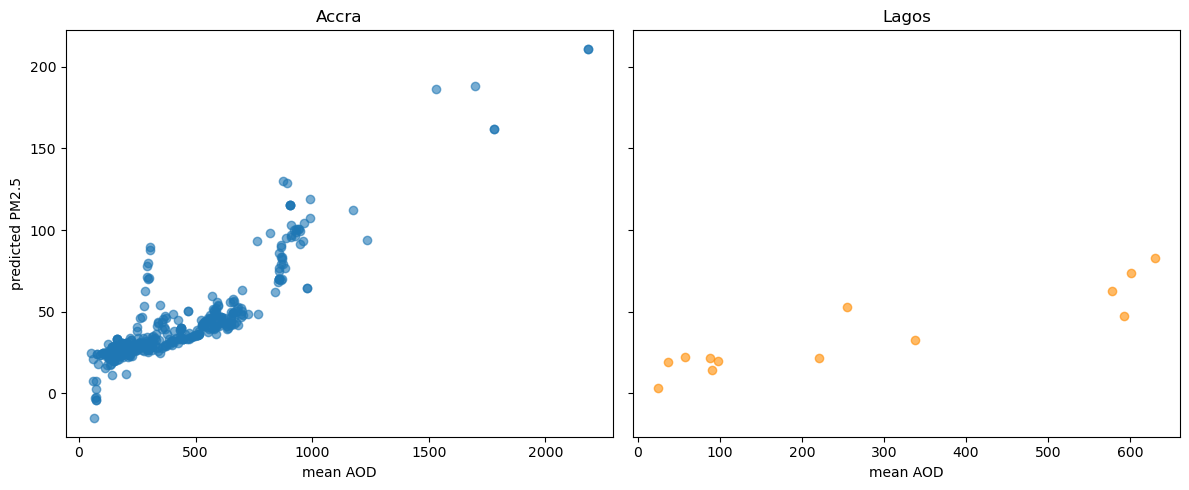

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axes[0].scatter(accra_gdf["mean_AOD"], accra_gdf["prediction"], alpha=0.6)
axes[0].set_title("Accra")
axes[0].set_xlabel("mean AOD")
axes[0].set_ylabel("predicted PM2.5")

axes[1].scatter(lagos_gdf["mean_AOD"], lagos_gdf["prediction"], alpha=0.6, color="darkorange")
axes[1].set_title("Lagos")
axes[1].set_xlabel("mean AOD")

plt.tight_layout()
plt.show()


In [107]:
PATCH_KM = 32
HALF_KM = PATCH_KM / 2.0
KM2DEG = 1/111.0
HALF_DEG_LAT = HALF_KM * KM2DEG  # ≃0.144°